In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### In this notebook, we use a descompose a covariance matrix with the spectral theorem and then we train a convolutional autoencoter to learn to generate fake covariance matrices. 

#### First, we need to read the data. In this case, we use the covariance matrix of systematic erros from Pantheon compilation of SN-1a 

In [2]:
syscov = np.loadtxt('https://raw.githubusercontent.com/ja-vazquez/SimpleMC/master/simplemc/data/pantheon_sys_full_long.txt',skiprows=1).reshape((1048,1048))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

3

### Visualization of the covariance matrix:

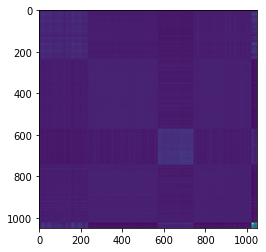

In [4]:
plt.imshow(syscov)

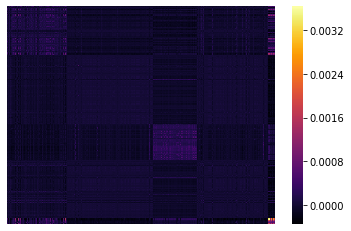

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')


In [6]:
np.min(np.abs(syscov.diagonal())) #checking non-negatives in the diagonal

3.5145e-05

### Generate a data set with covariance matrix from the original plus gaussian noise

In [7]:
numMatrix = 100
noise_factor = 1e-5
covset = np.zeros((numMatrix, 1048, 1048))
for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    covset[i] = syscov  + noise_factor * np.random.normal(loc=0.0, scale=0.01, size=syscov.shape) 
#     fig = plt.figure(figsize=(6,6))
#     sns.heatmap(pd.DataFrame(pset[i]*maxval), 
#             fmt='g', xticklabels=False, yticklabels=False, 
#             cmap = 'inferno', cbar=False,
#             robust=False)
#     fig.savefig('image/covMatrix_{}.png'.format(i), dpi=300, )
#     plt.clf()

 Generating 100 matrix 

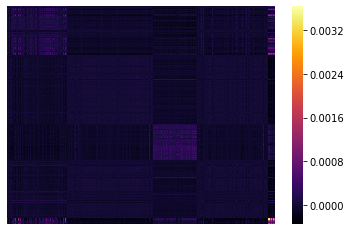

In [8]:
sns.heatmap(pd.DataFrame(covset[i]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [9]:
print(np.shape(covset))

(100, 1048, 1048)


(100, 1048, 1048)
(20, 1048, 1048) (80, 1048, 1048)


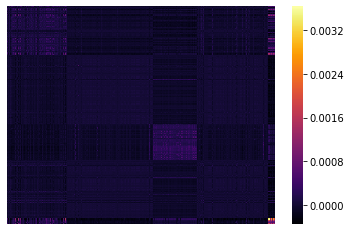

In [10]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
print(np.shape(covset_test), np.shape(covset_train))
sns.heatmap(pd.DataFrame(covset_train[0, :, :]), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [11]:
input_cov = Input(shape=(1048, 1048, 1))

x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(input_cov)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)

x = layers.MaxPooling2D((2, 2), padding='same')(x)

# x = layers.Flatten()(x)
# encoded = Dense(1048, activation='relu')(x)
# x = Dense(131*131*2, activation='relu')(encoded)
# x = layers.Reshape((131,131,2))(x)

x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(x)

autoencoder = tf.keras.Model(input_cov, decoded)
optimizer = tf.keras.optimizers.Adam()
# optimizer = tf.keras.optimizer.SGD()

autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
# "log_cosh"
# "cosine_similarity"
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1048, 1048, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1048, 1048, 2)     20        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 524, 524, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 524, 524, 4)       76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 262, 262, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 262, 262, 2)       74        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 131, 131, 2)      

In [12]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=100, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_train, covset_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(covset_test, covset_test),
                callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
2/2 [==============================] - 8s 4s/step - loss: 1.0488e-07 - val_loss: 1.4442e-07
Epoch 2/50
2/2 [==============================] - 8s 4s/step - loss: 2.0265e-07 - val_loss: 9.8269e-08
Epoch 3/50
2/2 [==============================] - 8s 4s/step - loss: 8.8486e-08 - val_loss: 2.3888e-07
Epoch 4/50
2/2 [==============================] - 8s 4s/step - loss: 2.2811e-07 - val_loss: 3.1910e-08
Epoch 5/50
2/2 [==============================] - 8s 4s/step - loss: 3.3061e-08 - val_loss: 1.3776e-07
Epoch 6/50
2/2 [==============================] - 8s 4s/step - loss: 1.3667e-07 - val_loss: 4.2958e-08
Epoch 7/50
2/2 [==============================] - 8s 4s/step - loss: 3.6873e-08 - val_loss: 6.4060e-08
Epoch 8/50
2/2 [==============================] - 8s 4s/step - loss: 7.0392e-08 - val_loss: 5.8527e-08
Epoch 9/50
2/2 [==============================] - 8s 4s/step - loss: 4.9589e-08 - val_loss: 2.1775e-08
Epoch 10/50
2/2 [==============================] - 8s 4s/step - loss: 2.8

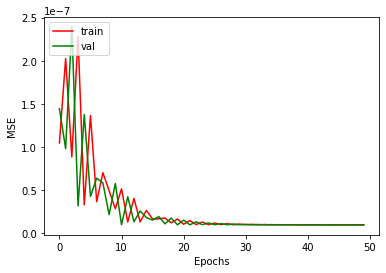

In [22]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_100ep_mse.png')

In [14]:
print(np.shape(covset_test))
decoded_imgs = autoencoder.predict(covset_test)
print(np.shape(decoded_imgs))

decoded_imgs[0, :, :, 0]

(20, 1048, 1048)
(20, 1048, 1048, 1)


array([[-1.02736112e-05, -1.02736112e-05, -1.02736112e-05, ...,
        -1.02736112e-05, -1.02736112e-05, -1.02736112e-05],
       [-1.02736112e-05, -1.02736112e-05, -1.02736112e-05, ...,
         6.27685877e-05,  7.88858088e-05, -4.39816431e-05],
       [-1.02736112e-05, -1.02736112e-05, -1.02736112e-05, ...,
         4.11977308e-05,  8.02906725e-05, -6.73644536e-05],
       ...,
       [-1.02736112e-05, -5.48778880e-05, -3.58946818e-05, ...,
         1.04718521e-04, -1.72871914e-05,  4.92810941e-05],
       [-1.02736112e-05, -4.52810455e-05, -3.65197047e-05, ...,
         1.10535620e-04, -6.97985070e-06,  4.99298840e-05],
       [-1.02736112e-05, -1.02736112e-05, -1.02736112e-05, ...,
         1.01773185e-04,  1.92702319e-05,  9.35033895e-05]], dtype=float32)

(20, 1048, 1048, 1)
266.6666666666667


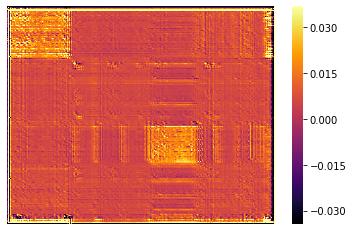

In [36]:
print(np.shape(decoded_imgs))
cte = 0.032/0.00012
print(cte)

sns.heatmap(pd.DataFrame(decoded_imgs[0, :, : ,0]*4e3), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=True)
# plt.savefig("decoded_img22.png")

In [16]:
print(np.shape(decoded_imgs))

(20, 1048, 1048, 1)


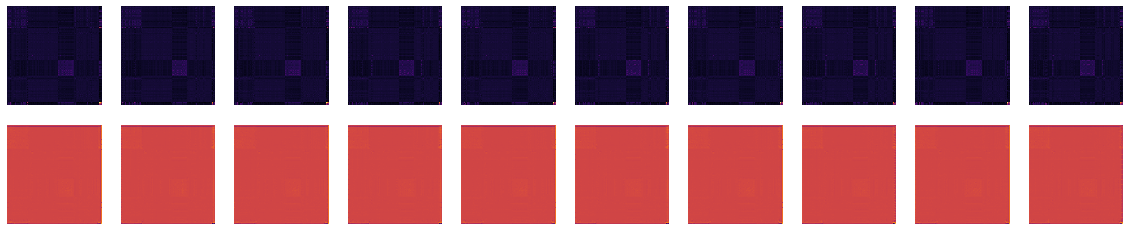

In [24]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # Display original
    ax = plt.subplot(2, n, i)
#     sns.heatmap(pd.DataFrame(scaler.inverse_transform(evec_test[i, :, :])), 
    sns.heatmap(pd.DataFrame(covset_test[i-1, :, :]), 
                xticklabels=False, yticklabels=False, 
                cmap = 'inferno', 
                robust=False, cbar=False)
     # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    sns.heatmap(pd.DataFrame(decoded_imgs[i-1, :, :, 0]*cte),
                xticklabels=False, yticklabels=False, 
                cmap = 'inferno', 
                robust=False, cbar=False)

plt.show()

In [19]:
# print(np.min(scaler.inverse_transform(evec_test[0, :, :])), np.min(decoded_imgs[0, :, :, 0]))
print(np.min(covset_test[0, :, :]), np.min(decoded_imgs[0, :, :, 0]))

-0.0003366428925424138 -0.00019064608


In [20]:
pprima = decoded_imgs[0,:,:,0]
new_matrix = pprima @ D @ pprima.T

sns.heatmap(pd.DataFrame(new_matrix),
            xticklabels=False, yticklabels=False, 
            cmap = 'inferno', fmt='g',
            robust=False)

NameError: name 'D' is not defined

In [ ]:
# np.savetxt('fake_cov.dat', new_matrix, delimiter=" ", header="1048x1048")

### Use matrix descomposition (spectral theorem) (NOT USE THIS FOR NOW)

### $\Sigma = P D P^T$

#### where P is an orthogonal matrix with the eigenvectors from $\Sigma$ and D a diagonal matrix with its eigenvalues.

In [ ]:
# eigenval, eigenvec = sp.linalg.eigh(syscov)
D, P = sp.linalg.eigh(syscov)
D = np.diag(D)
rec_cov = P @ D @ P.T
sns.heatmap(pd.DataFrame(rec_cov), annot=False, fmt='g', xticklabels=False, yticklabels=False, )

In [ ]:
count = 0

for i in range(len(P)):
    for j in range(len(P)):
        if np.iscomplex(P[i,j]):
#             print("COMPLEX")
            count+=1
#             print(i,j)
#             print(eigenvec[i,j])

print(count)